In [122]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('280tsp.txt', newline='') as file:
    lines = file.readlines()

In [3]:
newlines = [l[:-1].lstrip(' ') for l in lines]
with open('280tsp_.txt', 'w') as f:
    for line in newlines:
        f.write(line)
        f.write('\n')

In [4]:
eil51 = pd.read_csv('51tsp.txt', delimiter=' ', index_col= 0, header = None, names = ['x','y'])
a280 = pd.read_csv('280tsp.csv', delimiter=',', index_col= 0, header = None, names = ['x','y'])

In [5]:
with open('eil51.opt.tour.txt', newline='') as file:
    lines = file.readlines()
opt51 = [int(l[:-1]) for l in lines]
with open('a280.opt.tour.txt', newline='') as file:
    lines = file.readlines()
opt280 = [int(l[:-1]) for l in lines]

In [6]:
def distance_matrix(df):
    matrix = pd.DataFrame(data = np.zeros((len(df), len(df))), index = np.arange(1,len(df)+1),columns = np.arange(1,len(df)+1))
    for index1, cor1 in df.iterrows():
        for index2, cor2 in df.iterrows():
            diff_x = cor1["x"] - cor2["x"]
            diff_y = cor1["y"] - cor2["y"]
            distance = (diff_x**2 + diff_y**2)**0.5
            matrix.loc[index1, index2] = distance
    return matrix

def distance(d_df, route):
    distance = 0
    for i in range(len(route)-1):
        distance += d_df.loc[route[i], route[i+1]]
    return distance

In [14]:
def insert(route):
    new_route = route[1:-1]
    m, n = random.sample(range(0, len(new_route)), 2)
    city = new_route[m]
    new_route.remove(city)
    new_route.insert(n, city)
    return [1] + new_route + [1]
def swap(route):
    new_route = route[1:-1]
    pos_1, pos_2 = random.sample(range(0, len(new_route)), 2)
    new_route[pos_1], new_route[pos_2] = new_route[pos_2], new_route[pos_1]
    return [1] + new_route + [1]
def inverse(route):
    copy_route = route[1:-1]
    pos_1, pos_2 = random.sample(range(0, len(copy_route)), 2)
    if pos_2 < pos_1:
        pos_1, pos_2 = pos_2, pos_1
    inversed = copy_route[pos_1:pos_2][::-1]
    new_route = copy_route[0:pos_1] + inversed + copy_route[pos_2:]
    return [1] + new_route + [1]

In [15]:
def main_sa(d_df, route0, mutate, mc_len, sch_method, t0, stop):
    d_list = [distance(d_df, route0)]
    t = t0
#     t_list = [t]
    best_route = route0[:]
    k = 0
    for k in range(stop):
        k+=1
        for i in range(mc_len):
            new_route = mutate(best_route)
            new_distance = distance(d_df, new_route)
            diff_distance = distance(d_df, best_route) - new_distance
            if diff_distance > 0: 
                best_route = new_route
            else:
                p = np.e**(diff_distance/t)
                if random.uniform(0, 1) < p:
                    best_route = new_route
        d_list.append(distance(d_df, best_route))
        if sch_method == "linear": #additive
            t = t - t0/stop
        elif sch_method == "geometric":
            t = t * 0.99
        elif sch_method == "logarithmic":
            t = t0/(1+2*np.log(1+k))

#         t_list.append(t)
        
    return d_list, best_route

Investigate permutation method

In [17]:
data = eil51
d_df = distance_matrix(data)
mc_length = [100]
cool_schedules = ['geometric']
t0 = 100
simulations = 10
stop = 1000
methods = [insert, swap]

results = pd.DataFrame()
for method in methods:
    for cooling in cool_schedules:
        for mc_len in mc_length:
            for s in range(simulations):
                random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,52)), len(data.index)-1)] + [1]
                d_list, best_route = main_sa(d_df, random_route, method, mc_len, cooling, t0, stop)
                df_dict = {
                  "simulation": [s],
                  "cooling schedules": [cooling],
                  "MC length": [mc_len],
                    "method": method,
                  "found_distances": [distance(d_df, best_route)]
                }
                df = pd.DataFrame.from_dict(df_dict)
                results = results.append(df)
                print(f'{method} {s+1}/{simulations} done {distance(d_df, best_route)}')
results.to_csv("mutation.csv", index=False)

Investigate t0

In [118]:
data = eil51
d_df = distance_matrix(data)
mc_length = [100]
cool_schedules = ['geometric']
t0s = [10,50,100,500,1000]
simulations = 10
stop = 1000

results = pd.DataFrame()
for t0 in t0s:
    for cooling in cool_schedules:
        for mc_len in mc_length:
            for s in range(simulations):
                random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,52)), len(data.index)-1)] + [1]
                d_list, best_route = main_sa(d_df, random_route, insert, mc_len, cooling, t0, stop)
                df_dict = {
                  "simulation": [s],
                  "cooling schedules": [cooling],
                  "MC length": [mc_len],
                    "t0": t0,
                  "found_distances": [distance(d_df, best_route)]
                }
                df = pd.DataFrame.from_dict(df_dict)
                results = results.append(df)
                print(f'{t0} {s+1}/{simulations} done')
results.to_csv("t0_50.csv", index=False)

Test for convergence (eil51)

In [63]:
data = eil51
d_df = distance_matrix(data)
mc_length = [100]
cool_schedules = ['geometric']
t0 = 50
simulations = 10
stop = 1000

results = pd.DataFrame()
for cooling in cool_schedules:
    for mc_len in mc_length:
        for s in range(simulations):
            random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,52)), len(data.index)-1)] + [1]
            d_list, best_route = main_sa(d_df, random_route, insert, mc_len, cooling, t0, stop)
            df_dict = {
              "simulation": [s],
              "cooling schedules": [cooling],
              "MC length": [mc_len],
              "found_distances": [distance(d_df, best_route)],
              "list": [d_list]
            }
            df = pd.DataFrame.from_dict(df_dict)
            results = results.append(df)
            print(f'{s+1}/{simulations} done')
results.to_csv("eil51.csv", index=False)

Cooling schedules

In [64]:
data = a280
d_df = distance_matrix(data)
mc_length = [100]
cool_schedules = ['linear','geometric','logarithmic']
t0 = 50
simulations = 10
stop = 1000

results = pd.DataFrame()
for cooling in cool_schedules:
    for mc_len in mc_length:
        for s in range(simulations):
            random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,len(data.index)+1)), len(data.index)-1)] + [1]
            d_list, best_route = main_sa(d_df, random_route, insert, mc_len, cooling, t0, stop)
            df_dict = {
              "simulation": [s],
              "cooling schedules": [cooling],
              "MC length": [mc_len],
              "found_distances": [distance(d_df, best_route)],
              "list": [d_list],
              "route":[best_route]
            }
            df = pd.DataFrame.from_dict(df_dict)
            results = results.append(df)
            print(f'{s+1}/{simulations} done')
results.to_csv("cooling.csv", index=False)

MC length

In [54]:
data = a280
d_df = distance_matrix(data)
mc_length = [1000]
cool_schedules = ['geometric']
t0 = 50
simulations = 1
stop = 1000

results = pd.DataFrame()
for cooling in cool_schedules:
    for mc_len in mc_length:
        for s in range(simulations):
            random_route = [1] + [int(x) for x in random.sample(list(np.arange(2,len(data.index)+1)), len(data.index)-1)] + [1]
            d_list, best_route = main_sa(d_df, random_route, insert, mc_len, cooling, t0, stop)
            df_dict = {
              "simulation": [s],
              "cooling schedules": [cooling],
              "MC length": [mc_len],
              "found_distances": [distance(d_df, best_route)],
              "list": [d_list],
              "route":[best_route]
            }
            df = pd.DataFrame.from_dict(df_dict)
            results = results.append(df)
            print(f'{s+1}/{simulations} done')
results.to_csv("mc1000.csv", index=False)

1/1 done


PLOT

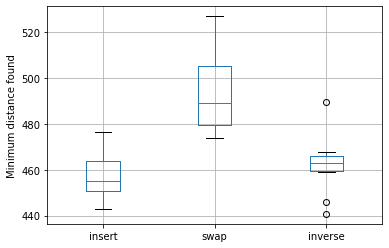

In [61]:
mutation = pd.read_csv('mutation.csv')
df = pd.DataFrame.from_dict({'insert': np.array(mutation[mutation['method']=='insert']['found_distances']),
                             'swap': np.array(mutation[mutation['method']=='swap']['found_distances']),
                             'inverse': np.array(mutation[mutation['method']=='inverse']['found_distances'])})
fig, ax = plt.subplots()
ax = df.boxplot()
ax.set_ylabel('Minimum distance found')
fig.savefig('mutation',dpi=500)

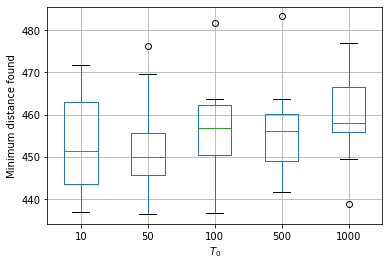

In [60]:
t0 = pd.read_csv('t0.csv')
df = pd.DataFrame.from_dict({'10': np.array(t0[t0['t0'] == 10] ['found_distances']),
                             '50': np.array(t0[t0['t0'] == 50] ['found_distances']),
                             '100': np.array(t0[t0['t0'] == 100] ['found_distances']),
                             '500': np.array(t0[t0['t0'] == 500] ['found_distances']),
                             '1000': np.array(t0[t0['t0'] == 1000] ['found_distances'])})
fig, ax = plt.subplots()
ax = df.boxplot()
ax.set_ylabel('Minimum distance found')
ax.set_xlabel(r'$T_0$')
fig.savefig('T0',dpi=500)

In [113]:
np.array(t0[t0['t0']==10]['found_distances'])

array([436.96065037, 471.62885178, 452.19619267, 450.37389511,
       444.42300741, 459.72832139, 463.95682929, 440.12274461,
       465.27391182, 443.34681745])

cooling schedules

In [ ]:
cooling = pd.read_csv('cooling.csv')
cools = pd.DataFrame()
for i in range(len(cooling)):
    row = cooling.iloc[i,:-1]
    d_list = eval(cooling.iloc[i,-1])
    df = pd.DataFrame([row]*len(d_list))
    df['k'] = np.arange(0,1001)
    df['d'] = d_list
    cools = cools.append(df)

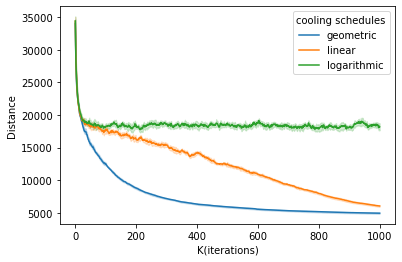

In [128]:
fig, ax = plt.subplots()
sns.lineplot(ax =ax, x = 'k', y = 'd', hue = 'cooling schedules', data=cools)
ax.set_ylabel('Distance')
ax.set_xlabel('K(iterations)')
fig.savefig('cooling.png',dpi=1000)

MC length

In [135]:
mc = pd.read_csv('mc.csv')
mc100 = pd.read_csv('a280_g.csv')
mc = mc.append(mc100)
mcs = pd.DataFrame()
for i in range(len(mc)):
    row = mc.iloc[i,:-2]
    d_list = eval(mc.iloc[i,-2])
    df = pd.DataFrame([row]*len(d_list))
    df['k'] = np.arange(0,1001)
    df['d'] = d_list
    mcs = mcs.append(df)

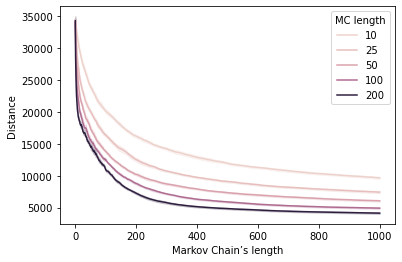

In [140]:
fig, ax = plt.subplots()
sns.lineplot(ax = ax, x = 'k', y = 'd', hue = 'MC length', data=mcs)
ax.set_ylabel('Distance')
ax.set_xlabel('Markov Chain’s length')
fig.savefig('mc.png',dpi=1000)